In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
from IPython import display
import math

## 1. Scaled Dot-product Self Attention

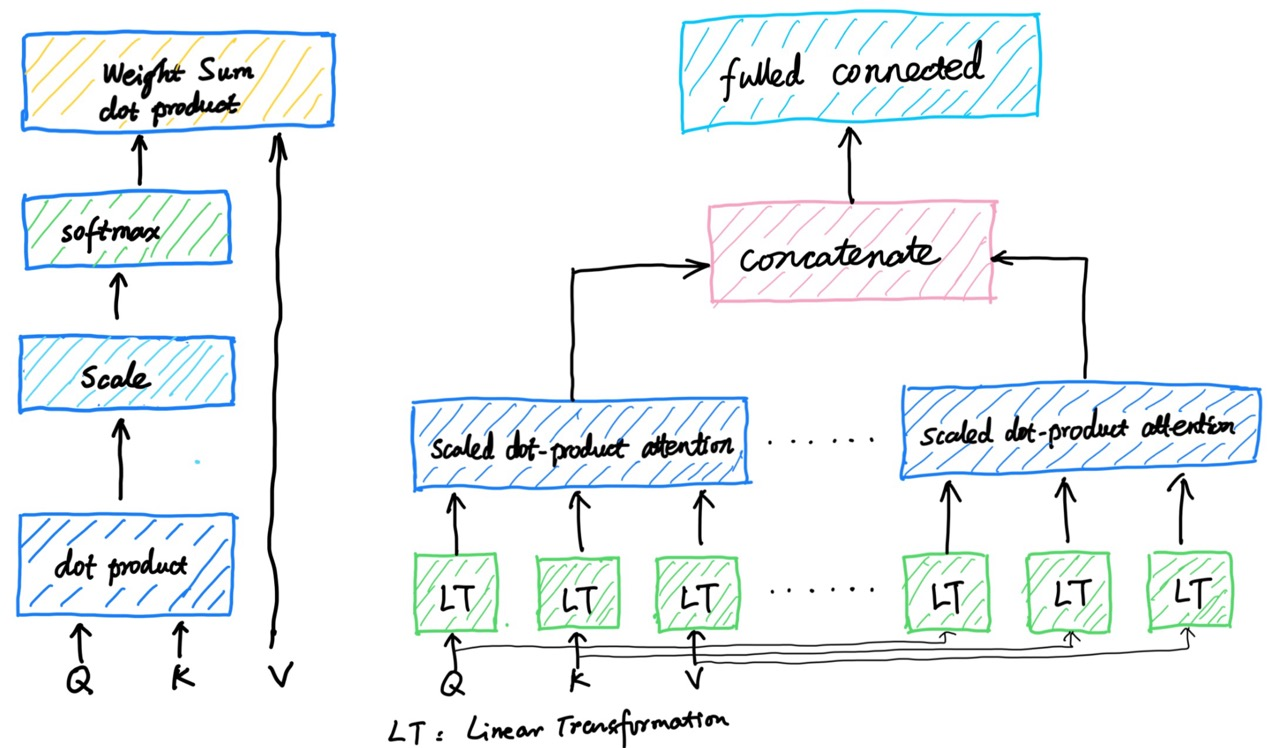

In [52]:
display.Image('Attention_components.jpeg', width=600)

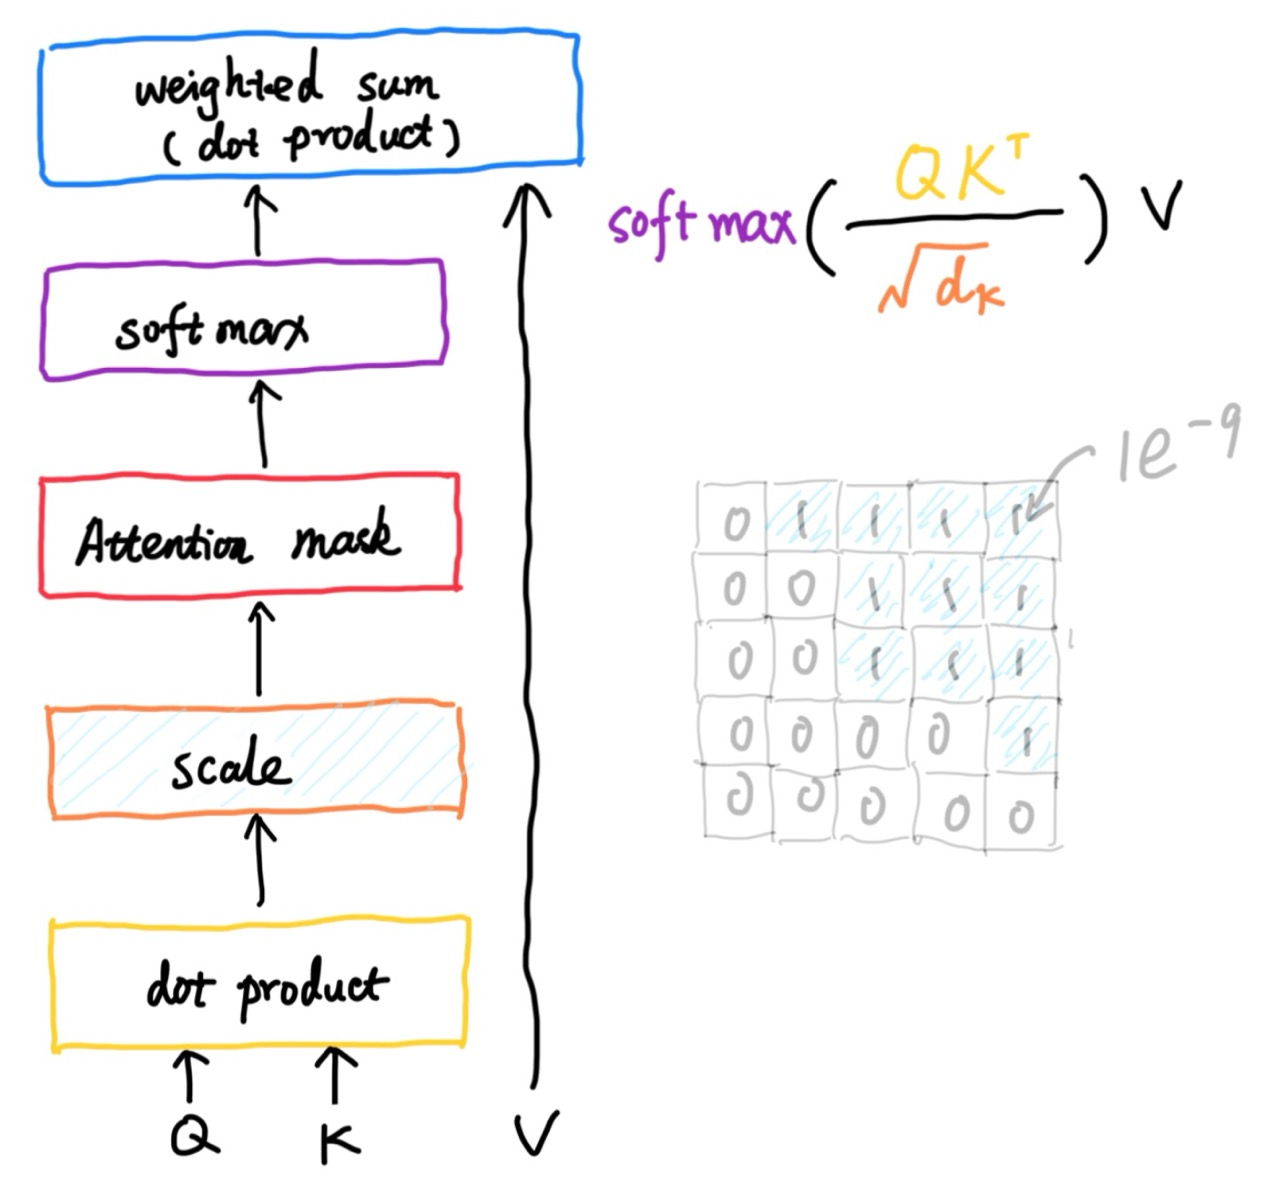

In [54]:
display.Image('scaled_attention.jpeg', width=350)

In [61]:
d_k = 64  #Q(=K) dimension
d_v = 64

class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()        
    def forward(self, Q, K, V, attn_mask):
        
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k) 
          
        scores.masked_fill_(attn_mask, -1e9) 
        
        weights = nn.Softmax(dim=-1)(scores) 
        
        context = torch.matmul(weights, V) 
         
        return context, weights # 返回上下文向量和注意力分数


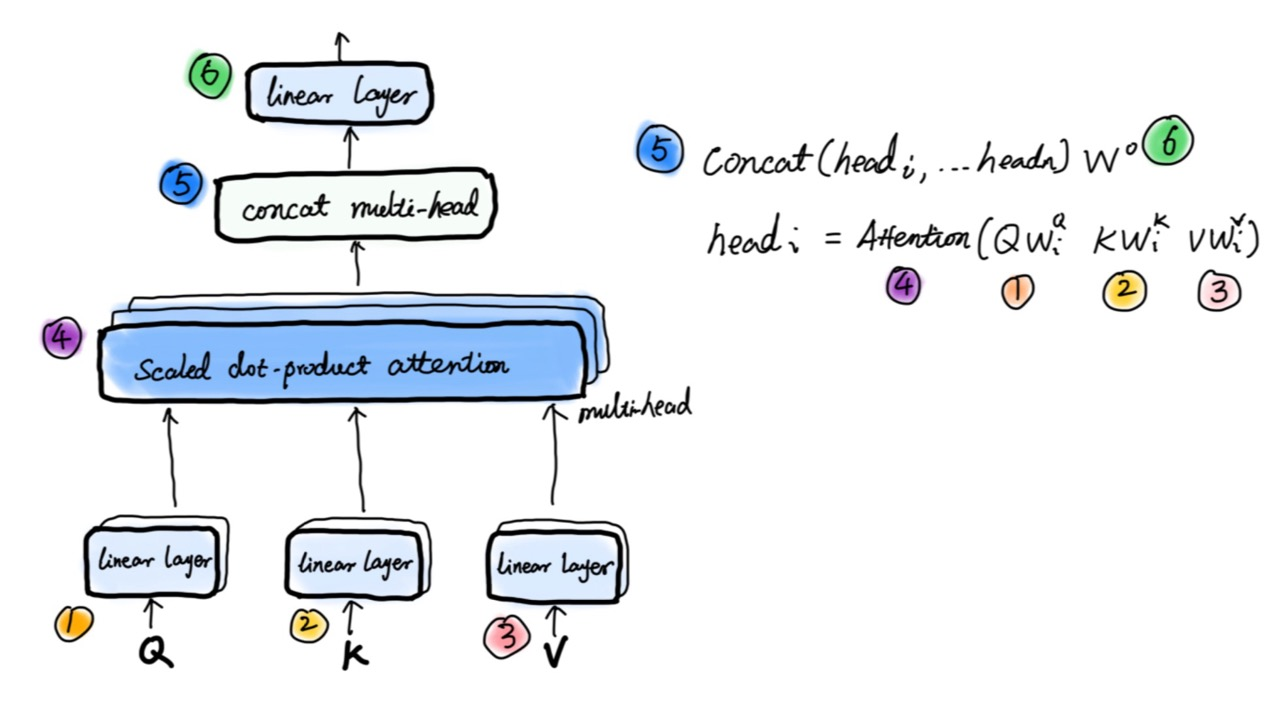

In [10]:
display.Image('Multi head Attention.jpeg', width = 650)

In [67]:
d_embedding = 512
n_heads = 8
batch_size = 3  

class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()

        self.W_Q = nn.Linear(d_embedding,d_k*n_heads)  # Q linear layer->input:d_embedding, output:dim_k*n_heads
        self.W_K = nn.Linear(d_embedding,d_k*n_heads)
        self.W_V = nn.Linear(d_embedding,d_v*n_heads)
        self.linear = nn.Linear(n_heads * d_v, d_embedding)
        self.layer_norm = nn.LayerNorm(d_embedding)

    def forward(self, Q, K, V, attn_mask):

        ## Q, K, V[batch_size, len_q/k/v, embedding_dim]

        residual, batch_size = Q, Q.size(0)

        # step 1,2,3
        # view() convert d_k*n_heads to [n_heads, d_k], 
        # -1 is a placeholder for len_q/k/v, which is infered by other dimensions
        # transpose() exchange 2nd and 3rd dimension
        q_s = self.W_Q(Q).view(batch_size, -1, n_heads, d_k).transpose(1,2)
        k_s = self.W_K(K).view(batch_size, -1, n_heads, d_k).transpose(1,2)
        v_s = self.W_V(V).view(batch_size, -1, n_heads, d_v).transpose(1,2)
        
        ## q_s, k_s, v_s[batch_size, n_heads, len_q/k/v, d_k/d_v]

        ## attn_mask [batch_size, len_q, len_k]
        ## with unsqueeze(1) [batch_size, 1, len_q, len_k]
        attn_mask = attn_mask.unsqueeze(1).repeat(1,n_heads, 1,1)
        ## attn_mask becomes [batch_size, n_heads, len_q, len_k]

        #step 4
        context, attn_weights = ScaledDotProductAttention()(q_s, k_s, v_s, attn_mask)
        ## context [batch_size, n_heads, len_q, d_v]
        ## weight [batch_size, n_heads, len_q, len_k]

        #step 5
        context = context.transpose(1,2).contiguous().view(batch_size, -1, n_heads*d_v)
        ## context [batch_size, len_q, n_heads*d_v]
        
        #step 6
        output = self.linear(context)

        output = self.layer_norm(output+residual)
        ## output [batch_size, len_q, embedding_dim]
       
        return output, attn_weights

## 2. Position-wise Feed-Forward Network
- the FNN process on each position of attention results independantly
- keeps the orignial sequence as is: no distube, no combination, no repeats
- so attention is all you need. 

In [70]:
class PoswiseFeedForward(nn.Module):
    def __init__(self, d_ff=2048):
        super(PoswiseFeedForward, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=d_embedding, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_embedding, kernel_size=1)
        self.layer_norm = nn.LayerNorm(d_embedding)

    def forward(self, inputs):

        ## inputs [batch_size, len_q, embedding_dim]
        residual = inputs
        output = nn.ReLU()(self.conv1(inputs.transpose(1,2)))
        ## output [batch_size, d_ff, len_q]

        output = self.conv2(output).transpose(1,2)
        ## output [batch_size, len, embedding_dim]

        output = self.layer_norm(output)

        return output        

In [6]:
def get_sin_enc_table(n_pos, d_embedding):

    sin_table = np.zeros((n_pos, d_embedding))

    for i in range(n_pos) :
        for j in range(d_embedding):
            angle = i/np.power(10000, 2*(j//2)/d_embedding)   # why j//2?
            sin_table[i,j] = angle
    sin_table[:,0::2] = np.sin(sin_table[:,0::2])
    sin_table[:,1::2] = np.cos(sin_table[:,1::2])
    return torch.FloatTensor(sin_table) 

n_pos = 5
d_embedding = 8
get_sin_enc_table(n_pos, d_embedding)

tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
          1.0000e+00,  0.0000e+00,  1.0000e+00],
        [ 8.4147e-01,  5.4030e-01,  9.9833e-02,  9.9500e-01,  9.9998e-03,
          9.9995e-01,  1.0000e-03,  1.0000e+00],
        [ 9.0930e-01, -4.1615e-01,  1.9867e-01,  9.8007e-01,  1.9999e-02,
          9.9980e-01,  2.0000e-03,  1.0000e+00],
        [ 1.4112e-01, -9.8999e-01,  2.9552e-01,  9.5534e-01,  2.9996e-02,
          9.9955e-01,  3.0000e-03,  1.0000e+00],
        [-7.5680e-01, -6.5364e-01,  3.8942e-01,  9.2106e-01,  3.9989e-02,
          9.9920e-01,  4.0000e-03,  9.9999e-01]])

## 4. Padding mask

In [7]:
def get_attn_pad_mask(seq_q, seq_k):

    ## seq_q [batch_size, len_q]
    
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()

    # create a boolean matrix, where True is set to 0
    pad_attn_mask = seq_k.eq(0).unsqueeze(1)
    ## pad_attn_mask [batch_size, 1, len_k]

    # expand only copy available data, not introducing new data
    pad_attn_mask = pad_attn_mask.expand(batch_size, len_q, len_k)
    
    return pad_attn_mask

## 5. Encoder layer

In [8]:
class EncoderLayer(nn.Module):

    def __init__(self):
        super(EncoderLayer, self).__init__()
    
        self.enc_self_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForward()

    def forward(self,enc_inputs, enc_self_attn_mask):

        ## enc_inputs & enc_self_attn_mask [batch_size, seq_len, embedding_dim] 
        enc_outputs, attn_weights = self.enc_self_attn(enc_inputs,enc_inputs,
                                                       enc_inputs,enc_self_attn_mask)
        ## enc_outputs [batch_size, seq_len, embedding_dim]
        ## attn_weights [batch_size, n_heads, seq_len, seq_len]
        enc_outputs = self.pos_ffn(enc_outputs)

        return enc_outputs, attn_weights 

## 6. Encoder

In [54]:
n_layers = 6

class Encoder(nn.Module):

    def __init__(self, corpus):
        super(Encoder, self).__init__()        
        self.src_emb = nn.Embedding(len(corpus.src_vocab), d_embedding) # 词嵌入层
        self.pos_emb = nn.Embedding.from_pretrained(get_sin_enc_table(corpus.src_len+1, d_embedding), freeze=True) # 位置嵌入层
        self.layers = nn.ModuleList(EncoderLayer() for _ in range(n_layers))# 编码器层数

    def forward(self, enc_inputs):

        ## enc_inputs [batch_size, source_len]
        # to(enc_inputs) ensures the tensor is on the same device (CPU/GPU) and has the same dtype as enc_inputs
        pos_indices = torch.arange(1, enc_inputs.size(1)+1).unsqueeze(0).to(enc_inputs)
        ## pos_indices [1, source_len]

        enc_outputs = self.src_emb(enc_inputs) + self.pos_emb(pos_indices)
        ## enc_outputs [batch_size, seq_len, d_embeddig]

        enc_self_attn_mask = get_attn_pad_mask(enc_inputs, enc_inputs)
        ## enc_self_attn_mask [batch_size, len_q, len_k]

        enc_self_attn_weights = []

        for layers in self.layers:
            enc_outputs, enc_self_attn_weight = layers(enc_outputs, enc_self_attn_mask)
            enc_self_attn_weights.append(enc_self_attn_weight)

        return enc_outputs, enc_self_attn_weight
  

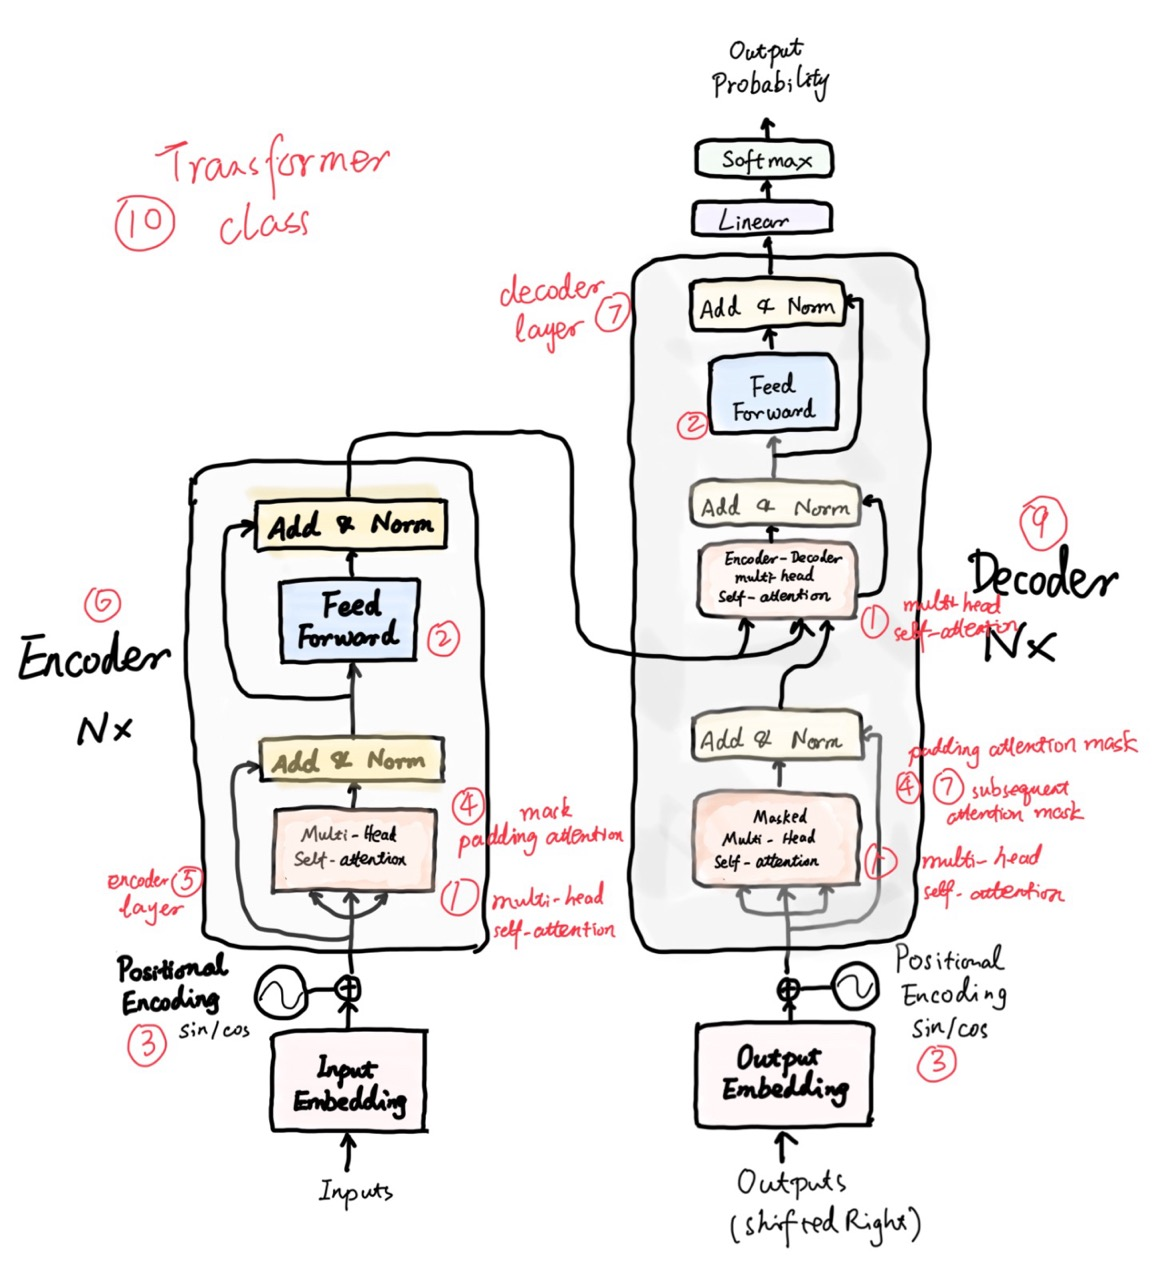

In [96]:
display.Image('Transformer Large.jpeg', width=600)

## 7. Subsequent attention mask

In [11]:
def get_sbq_attn_mask(seq):

    ## seq_q [batch_size, seq_len(q)=seq_len(k)]    
    attn_shape = [seq.size(0), seq.size(1), seq.size(1)]
        
    # create a upper triangular boolean matrix (2D array)
    # k=1: Starts from the first diagonal above the main diagonal.
    
    subsequent_mask = np.triu(np.ones(attn_shape), k=1)
    ## subsequent_mask [batch_size, seq_len, seq_len]

    subsequent_mask = torch.from_numpy(subsequent_mask).byte()
    
    return subsequent_mask

## 8. Decoder layer

In [79]:
class DecoderLayer(nn.Module):

    def __init__(self):
        super(DecoderLayer, self).__init__()
    
        self.dec_self_attn = MultiHeadAttention()  # multihead self-attention layer
        self.dec_enc_attn = MultiHeadAttention()  # multihead self-attention layer, connect encoder and decoder
        self.pos_ffn = PoswiseFeedForward()     # position-wise feed-forward network

    def forward(self,dec_inputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask):

        ## dec_inputs  [batch_size, target_len, embedding_dim]
        ## enc_inputs  [batch_size, source_len, embedding_dim]
        ## dec_self_attn_mask [batch_size, target_len, target_len]
        ## dec_enc_attn_mask [batch_size, target_len, source_len]
        dec_outputs, dec_self_attn = self.dec_self_attn(dec_inputs,dec_inputs,
                                                       dec_inputs,dec_self_attn_mask)

        dec_outputs, dec_enc_attn = self.dec_enc_attn(dec_outputs, enc_outputs, 
                                                      enc_outputs, dec_enc_attn_mask)

        ## enc_outputs [batch_size, seq_len, embedding_dim]
        ## attn_weights [batch_size, n_heads, seq_len, seq_len]
        enc_outputs = self.pos_ffn(enc_outputs)

        return enc_outputs, dec_self_attn, dec_enc_attn 

# 9. Decoder

In [76]:
n_layers = 6

class Decoder(nn.Module):
    def __init__(self, corpus):
        super(Decoder, self).__init__()

        self.tgt_emb = nn.Embedding(len(corpus.tgt_vocab), d_embedding)
        self.pos_emb = nn.Embedding.from_pretrained(get_sin_enc_table(corpus.tgt_len+1, d_embedding), freeze=True)
        self.layers = nn.ModuleList([DecoderLayer() for _ in range(n_layers)])

    def forward(self, dec_inputs, enc_inputs, enc_outputs):

        ## dec_inputs [batch_size, target_len]
        ## enc_inputs [batch_size, source_len]
        ## enc_outputs [batch_size, target_len, embedding_dim]
        
        pos_indices = torch.arange(1, dec_inputs.size(1)+1).unsqueeze(0).to(dec_inputs)
        ## pos_indices [1, target_len]

        dec_outputs = self.tgt_emb(dec_inputs) + self.pos_emb(pos_indices)
        ## dec_outputs [batch_size, target_len, embedding_dim]

        dec_self_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs)
        ## [batch_size, target_len, target_len]
        
        dec_self_attn_subsequent_mask = get_sbq_attn_mask(dec_inputs)
        ## [batch_size, target_len, target_len]
        
        dec_self_attn_mask = torch.gt((dec_self_attn_pad_mask + dec_self_attn_subsequent_mask),0)
        ## [batch_size, target_len, target_len]
        
        dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs)
        ## [batch_size, target_len, source_len]

        dec_self_attns, dec_enc_attns = [], [] 

        for layers in self.layers:
            dec_outputs, dec_self_attn, dec_enc_attn = layers(dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)
            ## dec_outputs [batch_size, target_len, embedding_dim]
            dec_self_attns.append(dec_self_attn)
            ## dec_self_attns is a list, each element dimension [batch_size, n_heads, target_len, target_len]
            dec_enc_attns.append(dec_enc_attn)
            ## dec_enc_attns is a list, each element dimension [batch_size, n_heads, target_len, source_len]

        return dec_outputs, dec_self_attns, dec_enc_attns
  

# 10. Transformer class

In [49]:
class Transformer(nn.Module):
    def __init__(self, corpus):
        super(Transformer, self).__init__()

        self.encoder = Encoder(corpus)
        self.decoder = Decoder(corpus)
        self.projection = nn.Linear(d_embedding, len(corpus.tgt_vocab), bias=False)

    def forward(self, enc_inputs, dec_inputs):

        ## enc_inputs [batch_size, source_seq_len]
        ## dec_inputs [batch_size, target_seq_len]

        enc_outputs, enc_self_attns = self.encoder(enc_inputs)
        ## dec_outputs [batch_size, target_len, embedding_dim]
        ## enc_self_attns is a list, each element dimension [batch_size, n_heads, src_seq_len, src_seq_len]

        dec_outputs, dec_self_attns, dec_enc_attns = self.decoder(dec_inputs, enc_inputs, enc_outputs)
        ## dec_outputs [batch_size, target_len, embedding_dim]
        ## dec_self_attns is a list, each element dimension [batch_size, n_heads, tgt_seq_len, src_seq_len]
        ## dec_enc_attns is a list, each element dimension [batch_size, n_heads, tgt_seq_len, src_seq_len]
        
        dec_logits = self.projection(dec_outputs)
        ## dec_logits [batch_size, tgt_seq_len, tgt_vocab_size]

        return dec_logits, enc_self_attns, dec_self_attns, dec_enc_attns
  

In [43]:
sentences = [
    ['我 爱 学习 人工智能', 'I love studying AI'],
    ['深度学习 改变 世界', ' DL changed the world'],
    ['自然语言处理 很 强大', 'NLP is powerful'],
    ['神经网络 非常 复杂', 'Neural-networks are complex'] ]

In [44]:
from collections import Counter

class TranslationCorpus:
    def __init__(self, sentences):
        self.sentences = sentences

        self.src_len = max(len(sentence[0].split()) for sentence in sentences) + 1
        self.tgt_len = max(len(sentence[1].split()) for sentence in sentences) + 2

        self.src_vocab, self.tgt_vocab = self.create_vocabularies()

        self.src_idx2word = {v:k for k, v in self.src_vocab.items()}
        self.tgt_idx2word = {v:k for k, v in self.tgt_vocab.items()}

    def create_vocabularies(self):
        src_counter = Counter(word for sentence in self.sentences for word in sentence[0].split())
        tgt_counter = Counter(word for sentence in self.sentences for word in sentence[1].split())

        src_vocab = {'<pad>': 0, **{word: i+1 for i, word in enumerate(src_counter)}}
        tgt_vocab = {'<pad>': 0, '<sos>': 1, '<eos>':2, **{word:i+3 for i, word in enumerate(tgt_counter)}}

        return src_vocab, tgt_vocab

    def make_batch(self, batch_size, test_batch=False):
        input_batch, output_batch, target_batch = [], [], []

        sentence_indices = torch.randperm(len(self.sentences))[:batch_size]
        for index in sentence_indices:
            src_sentence, tgt_sentence = self.sentences[index]
            src_seq = [self.src_vocab[word] for word in src_sentence.split()]
            tgt_seq = [self.tgt_vocab['<sos>']]+[self.tgt_vocab[word] for word in tgt_sentence.split()]+[self.tgt_vocab['<eos>']]

            src_seq += [self.src_vocab['<pad>']]*(self.src_len-len(src_seq))
            tgt_seq += [self.tgt_vocab['<pad>']]*(self.tgt_len-len(tgt_seq)) 

            input_batch.append(src_seq)
            output_batch.append([self.tgt_vocab['<sos>']] + ([self.tgt_vocab['<pad>']]*(self.tgt_len-2)) if test_batch else tgt_seq[:-1])

            target_batch.append(tgt_seq[1:])
            input_batch = torch.LongTensor(input_batch)
            output_batch = torch.LongTensor(output_batch)
            target_batch = torch.LongTensor(target_batch)
            return input_batch, output_batch, target_batch

In [80]:
corpus = TranslationCorpus(sentences)

In [83]:
import torch 
import torch.optim as optim # import optimizer

model = Transformer(corpus) # create a Transformer object
criterion = nn.CrossEntropyLoss() # define loss function
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # define optimizer

epochs = 100  
for epoch in range(epochs):
    optimizer.zero_grad()   #set gradient to 0
    enc_inputs, dec_inputs, target_batch = corpus.make_batch(batch_size)
    outputs, _, _, _ = model(enc_inputs, dec_inputs)
    loss = criterion(outputs.view(-1, len(corpus.tgt_vocab)), target_batch.view(-1))
    if (epoch+1)%20==0:
        print(f"Epoch: {epoch+1:04d} cost = {loss:6f}")
    loss.backward()
    optimizer.step()

Epoch: 0020 cost = 1.217850
Epoch: 0040 cost = 0.928143
Epoch: 0060 cost = 0.063869
Epoch: 0080 cost = 0.338385
Epoch: 0100 cost = 0.009566


In [84]:
# create a batch_size = 1，target seq dec_inputs in test stage, only contain sentence start with <sos>
enc_inputs, dec_inputs, target_batch = corpus.make_batch(batch_size=1,test_batch=True) 
print("Encoder inputs :", enc_inputs) 
print("Decoder inputs :", dec_inputs) 
print("target :", target_batch) 
predict, enc_self_attns, dec_self_attns, dec_enc_attns = model(enc_inputs, dec_inputs) # use model to translate
predict = predict.view(-1, len(corpus.tgt_vocab)) # reshape the dimension of predict results 
predict = predict.data.max(1, keepdim=True)[1] # find the max prob. of each position in dict 
# Decoder pred. outputs，turn index to word in target sentence. 
translated_sentence = [corpus.tgt_idx2word[idx.item()] for idx in predict.squeeze()]
# turn index to words in source sentence 
input_sentence = ' '.join([corpus.src_idx2word[idx.item()] for idx in enc_inputs[0]])
print(input_sentence, '->', translated_sentence)

Encoder inputs : tensor([[1, 2, 3, 4, 0]])
Decoder inputs : tensor([[1, 0, 0, 0, 0]])
target : tensor([[3, 4, 5, 6, 2]])
我 爱 学习 人工智能 <pad> -> ['I', 'love', 'studying', 'AI', '<eos>']
